In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


#### Importing and preparing the data

In [2]:
# Read the data from CSV file
newData = pd.read_csv("Office_Garman.csv", index_col="timestamp", parse_dates=True)
# Remove duplicate entries
newData = newData.drop_duplicates()
# Set the frequency to hourly
newData = newData.asfreq('H')
# Fill missing values using forward fill method
newData = newData.fillna(method='ffill')

#### Visualizing the data

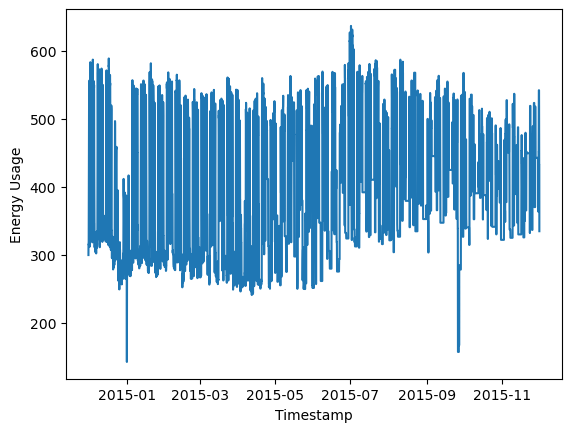

In [3]:
plt.plot(newData)
plt.xlabel('Timestamp')
plt.ylabel('Energy Usage')
plt.show()

#### Check for Stationarity

In [4]:
from statsmodels.tsa.stattools import adfuller

test_result=adfuller(newData['Office_Garman'])

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Office_Garman):
    result=adfuller(Office_Garman)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [5]:
adfuller_test(newData['Office_Garman'])

ADF Test Statistic : -11.660973171965004
p-value : 1.9338052604326435e-21
#Lags Used : 37
Number of Observations Used : 8722
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


#### Splitting the data for training and testing

In [6]:
# Define the split date
split_date = '2015-09-30'

# Split the data into training and testing sets
train = newData.loc[:split_date]
test = newData.loc[split_date:]


#### Plotting the ACF and PACF

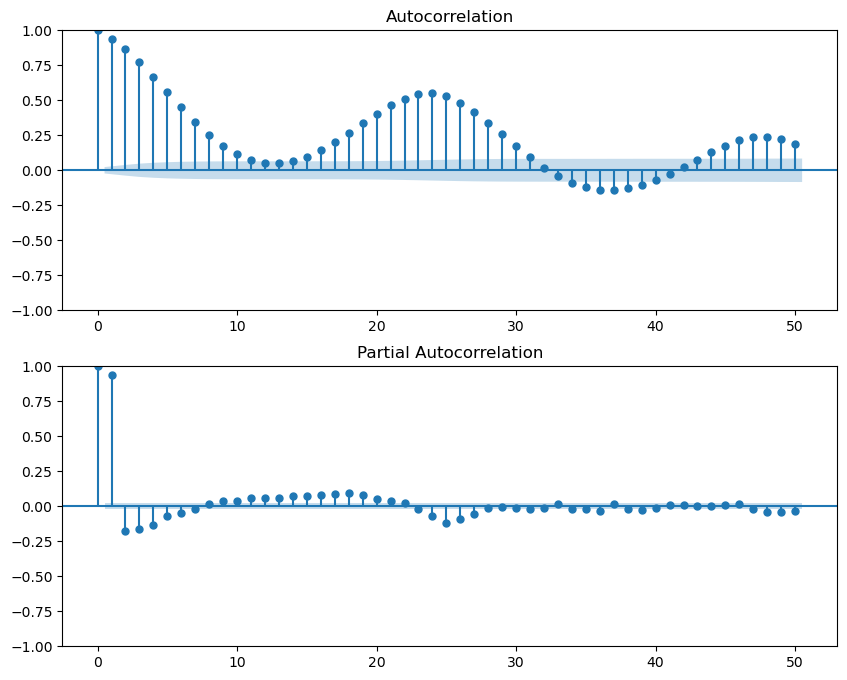

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(train, ax=ax1, lags=50)
plot_pacf(train, ax=ax2, lags=50)
plt.show()

#### Deciding the order of the p,d,q using auto_arima function

Selecting the best p, d, q values for an ARIMA model can be a challenging task. One approach is to use a grid search to iterate over different combinations of p, d, and q values and evaluate the performance of each model. The pmdarima library is used here, which provides an automated method to determine the optimal ARIMA parameters based on different evaluation criteria.

In [ ]:
import pmdarima as pm

# Perform grid search to find best p, d, q, P, D, Q values
model = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # Use the ADF test to determine stationarity
                      seasonal=True,    # Enable seasonality
                      m=24,             # Set the seasonal frequency
                      trace=True)       # Print detailed information

# Print the selected model's parameters
print(model.order)
print(model.seasonal_order)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=84301.021, Time=28.55 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=87022.163, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=70794.131, Time=19.51 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=78378.832, Time=14.41 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=108063.291, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=71276.278, Time=0.27 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=70696.525, Time=115.78 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=185.70 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=39.73 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=84593.089, Time=138.23 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=70653.321, Time=122.20 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=70728.433, Time=28.27 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=70587.031, Time=208.31 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=40.72 sec
 ARIMA

#### Fitting the ARIMA model (assuming there is no seasonality in the data)

In [34]:
from statsmodels.tsa.arima.model import ARIMA

# Fitting the ARIMA model
model = ARIMA(train, order=(5, 1, 1))
model_fit = model.fit()

# Printing the summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Office_Garman   No. Observations:                 7296
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -35317.525
Date:                Thu, 25 May 2023   AIC                          70649.050
Time:                        17:52:36   BIC                          70697.314
Sample:                    12-01-2014   HQIC                         70665.646
                         - 09-30-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0429      0.014     72.663      0.000       1.015       1.071
ar.L2         -0.0023      0.019     -0.123      0.902      -0.040       0.035
ar.L3         -0.0120      0.016     -0.740      0.460      -0.044       0.020
ar.L4         -0.0593      0.017     -3.517      0.000      -0.092      -0.026
ar.L5         -0.0768      0.013     -6.069      0.000      -0.102      -0.052
ma.L1         -0.9975      0.001  -1050.300      0.000      -0.999      -0.996
sigma2       938.5322      6.889    136.233      0.000     925.030     952.035
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             74434.09
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                             1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Evaluating the residuals

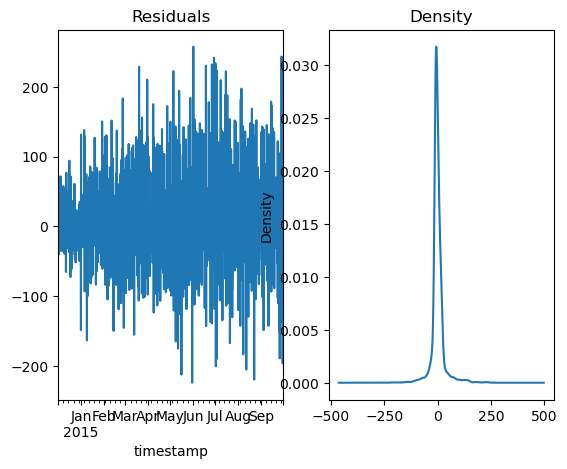

In [35]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

#### Predicting on the test set

In [36]:
# Make predictions on the test set
predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

# Display the predictions
print(predictions)


2015-09-30 00:00:00    303.007423
2015-09-30 01:00:00    303.555183
2015-09-30 02:00:00    306.115329
2015-09-30 03:00:00    318.582500
2015-09-30 04:00:00    334.692764
                          ...    
2015-11-30 19:00:00    406.601187
2015-11-30 20:00:00    406.601187
2015-11-30 21:00:00    406.601187
2015-11-30 22:00:00    406.601187
2015-11-30 23:00:00    406.601187
Freq: H, Name: predicted_mean, Length: 1488, dtype: float64


#### Plotting the predictions and actual data

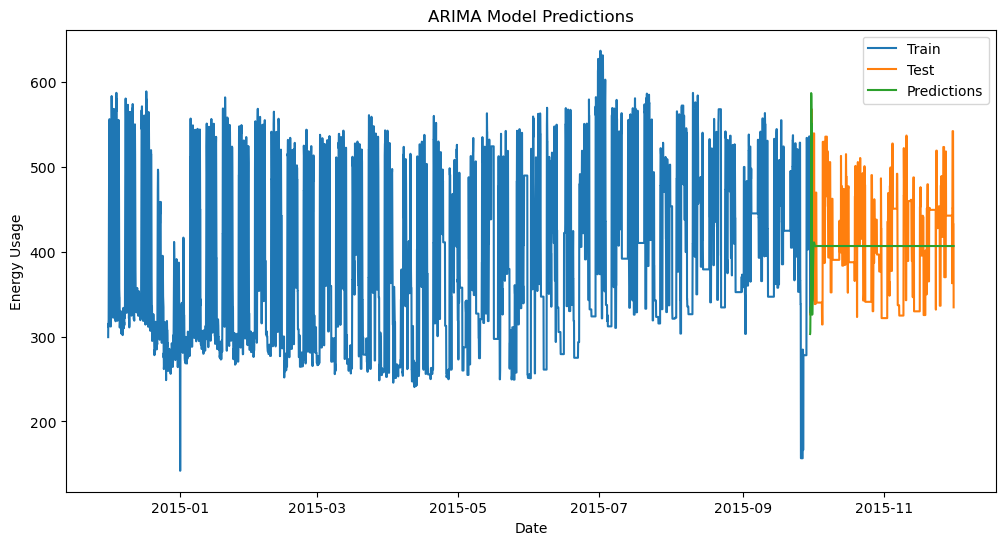

In [37]:
# Import the required libraries
import matplotlib.pyplot as plt

# Plotting the actual data and predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test')
plt.plot(predictions.index, predictions.values, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()


#### Evaluating the model predictions

In [38]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 51.11535410347226
mape - manual: 0.12758440861267178
rmse - manual: 60.218670077952666
